In [1]:
import json
import csv
import threading
import math
import pandas as pd
import numpy as np
import multiprocessing
import random as rn

import seaborn as sns
import matplotlib.pyplot as plt



# from data import data_visualization, data_loading, data_preprocessing
# from models import annModels

# from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.model_selection import  learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier

# import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Activation
from keras.optimizers import SGD
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.layers import concatenate
from sklearn.model_selection import StratifiedKFold

import joblib

2024-08-24 17:05:25.596660: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-24 17:05:25.610729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 17:05:25.627293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 17:05:25.631682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 17:05:25.643853: I tensorflow/core/platform/cpu_feature_guar

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical


# Load and preprocess data
def load_data():
    df = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_standard_csv_v3/final_dataset.csv')
    X = df.drop(['label', 'Unnamed: 0'], axis=True).values
    y = df['label'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_test, y_train, y_test, X_val, y_val

X_train, X_test, y_train, y_test, X_val, y_val = load_data()


In [9]:
y_test.shape

(83747,)

In [16]:
def predict_and_compile(model_paths, X_test, y_test):
    
    # Check if y_test is one-hot encoded or not
    if len(y_test.shape) == 1:
        y_test_labels = y_test  # Labels are already in 1D format
    else:
        y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to 1D class labels
    
    # Load models from the given paths
    X_test_cnn2d = np.reshape(X_test, (X_test.shape[0], 41, 1, 1))

    ann_model = load_model(model_paths[0])
    cnn1d_model = load_model(model_paths[1])
    cnn2d_model = load_model(model_paths[2])

    # Predict probabilities using each model
    ann_prob = ann_model.predict(X_test)
    cnn1d_prob = cnn1d_model.predict(X_test)
    cnn2d_prob = cnn2d_model.predict(X_test_cnn2d)

    # Initialize a DataFrame with the actual test labels
    df = pd.DataFrame({'y_test': y_test_labels})
    
    # Add predicted probabilities to the DataFrame
    df['ann_class_0'] = ann_prob[:, 0]
    df['ann_class_1'] = ann_prob[:, 1]
    df['cnn1d_class_0'] = cnn1d_prob[:, 0]
    df['cnn1d_class_1'] = cnn1d_prob[:, 1]
    df['cnn2d_class_0'] = cnn2d_prob[:, 0]
    df['cnn2d_class_1'] = cnn2d_prob[:, 1]

    return df

# Example usage:
# Paths to the saved models
ann_model_path = '/home/devnath/Ember_18_Aug/model_save/ann_base_classfier.h5'
cnn1d_model_path = '/home/devnath/Ember_18_Aug/model_save/1dcnn_base_classfier.h5'
cnn2d_model_path = '/home/devnath/Ember_18_Aug/model_save/2dcnn_base_classfier.h5'





In [17]:
# Model paths list
model_paths = [ann_model_path, cnn1d_model_path, cnn2d_model_path]

In [18]:
# Call the function
result_df = predict_and_compile(model_paths, X_test, y_test)


2618/2618 ━━━━━━━━━━━━━━━━━━━━ 2s 791us/step
2618/2618 ━━━━━━━━━━━━━━━━━━━━ 2s 755us/step
2618/2618 ━━━━━━━━━━━━━━━━━━━━ 2s 760us/step


In [19]:
# Print the result
print(result_df.head())

   y_test   ann_class_0  ann_class_1  cnn1d_class_0  cnn1d_class_1  \
0       0  9.751474e-01     0.024853       0.840135       0.159865   
1       1  1.785613e-02     0.982144       0.002663       0.997337   
2       1  2.278264e-03     0.997722       0.000263       0.999736   
3       0  9.810533e-01     0.018947       0.970967       0.029033   
4       1  1.111912e-07     1.000000       0.000017       0.999983   

   cnn2d_class_0  cnn2d_class_1  
0       0.964754       0.035246  
1       0.001656       0.998344  
2       0.000027       0.999974  
3       0.995495       0.004505  
4       0.001243       0.998757  


In [20]:
result_df.shape

(83747, 7)

In [21]:
result_df.head(5)

,y_test,ann_class_0,ann_class_1,cnn1d_class_0,cnn1d_class_1,cnn2d_class_0,cnn2d_class_1
0,0,9.751474e-01,0.024853,0.840135,0.159865,0.964754,0.035246
1,1,1.785613e-02,0.982144,0.002663,0.997337,0.001656,0.998344
2,1,2.278264e-03,0.997722,0.000263,0.999736,0.000027,0.999974
3,0,9.810533e-01,0.018947,0.970967,0.029033,0.995495,0.004505
4,1,1.111912e-07,1.000000,0.000017,0.999983,0.001243,0.998757


In [22]:
result_df.to_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/stack_output_base.csv')

In [1]:
!nvidia-smi

Fri Aug 23 15:30:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000               Off | 00000000:47:00.0 Off |                  Off |
| 41%   35C    P8              15W / 140W |    513MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
!kill 341712 

In [ ]:
!kill 325766 

Epoch 1/50


/home/devnath/anaconda3/envs/ember_tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.6942 - loss: 1.9667 - val_accuracy: 0.9545 - val_loss: 1.4855 - learning_rate: 0.0010
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9502 - loss: 1.4278 - val_accuracy: 0.9550 - val_loss: 1.1499 - learning_rate: 0.0010
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9533 - loss: 1.1292 - val_accuracy: 0.9549 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9532 - loss: 0.9304 - val_accuracy: 0.9550 - val_loss: 0.7788 - learning_rate: 0.0010
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9534 - loss: 0.7715 - val_accuracy: 0.9553 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9520 - loss: 0.6517 - val_accuracy: 0.9552 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9547 - loss: 0.5508 - val_accuracy: 0.9552 - 

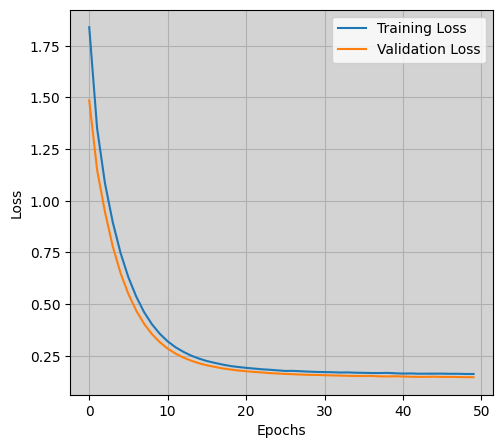

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('/home/devnath/Ember_18_Aug/ember/ember_csv/stack_output_base.csv')

# Split features and target
X = df.drop('y_test', axis=1).values
y = df['y_test'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define your model architecture
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu', 
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),  # Another Dropout layer
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')  # Adjust this output layer for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Change this to categorical_crossentropy for multi-class classification
              metrics=['accuracy'])

# Callbacks for reducing learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=4096,
                    callbacks=[reduce_lr, early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('lightgrey')

plt.show()


# # Plot the training and validation accuracy curves
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

# Generate the classification report
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])

# Print classification report
print("Classification Report:\n", report)

# Optional: Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:\n", conf_matrix)


524/524 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.95      0.97      0.96      8609
     Class 1       0.96      0.94      0.95      8141

    accuracy                           0.96     16750
   macro avg       0.96      0.95      0.96     16750
weighted avg       0.96      0.96      0.96     16750

Confusion Matrix:
 [[8309  300]
 [ 449 7692]]


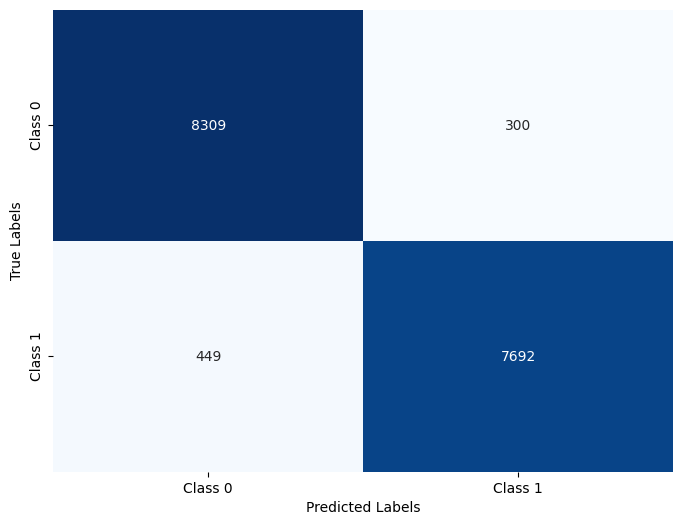

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()


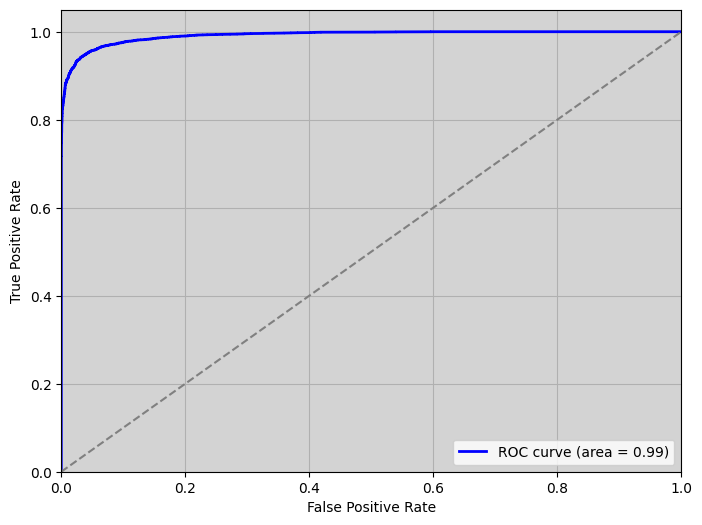

In [14]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.gca().set_facecolor('lightgrey')
plt.show()

In [5]:
from tensorflow.keras.models import load_model

# Save the trained model
model_1 = load_model('/home/devnath/Ember_18_Aug/model_save/meta_classfier.h5')

2024-08-25 16:22:19.785453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1146 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:47:00.0, compute capability: 8.6


In [6]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,395 (44.52 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)